#***HO-1.3. Amplitude Modification***

## Mengimpor Library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import os

## Memuat Audio

In [2]:
file_path = os.path.join(os.getcwd(), 'data', '/content/16_44k_PerfectTest.wav')

In [3]:
with wave.open(file_path, 'r') as wav_file:
    n_channels = wav_file.getnchannels()
    sampwidth = wav_file.getsampwidth()
    framerate = wav_file.getframerate()
    n_frames = wav_file.getnframes()
    audio_content = wav_file.readframes(n_frames)
    audio_data = np.frombuffer(audio_content, dtype=np.int16)

    if n_channels > 1:
        audio_data = audio_data.reshape(-1, n_channels)

## Normalisasi Audio

# Mengukur Amplitudo Maksimum

In [4]:
max_val = np.iinfo(np.int16).max
print(f"Max value: {max_val}")

Max value: 32767


In [5]:
normalized_audio = audio_data / np.max(np.abs(audio_data)) * max_val
normalized_audio = normalized_audio.astype(np.int16)


## Visualisasi

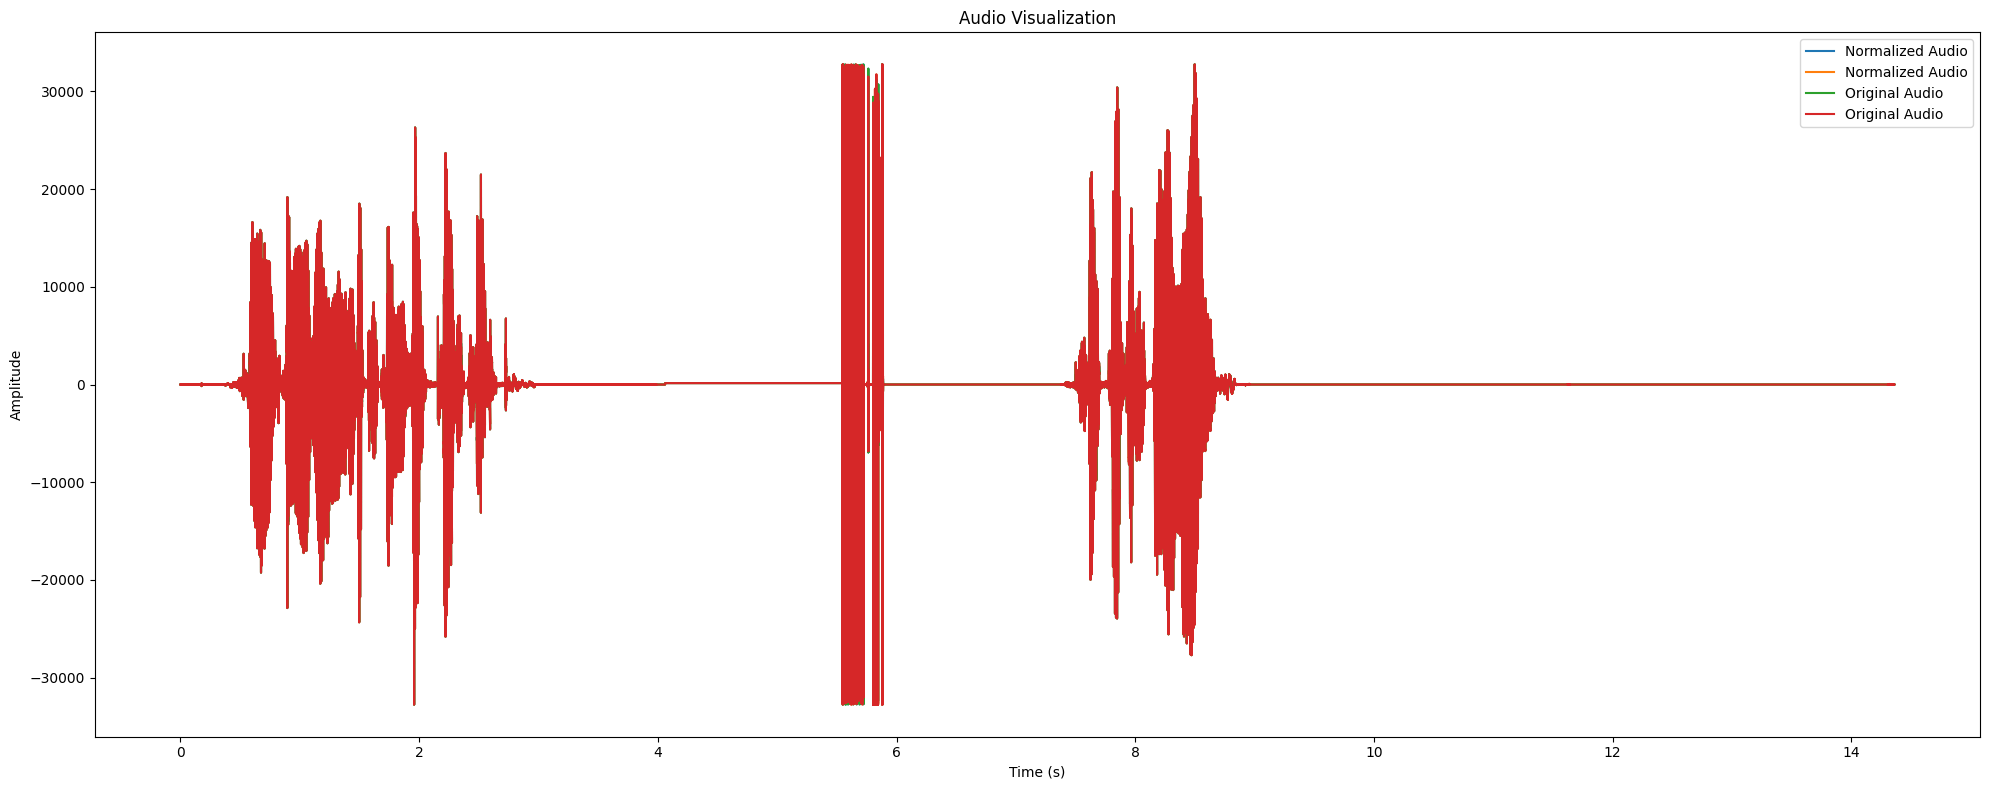

In [6]:
time_axis = np.linspace(0, len(audio_data) / framerate, num=len(audio_data))
# visualize in subplot
plt.figure(figsize=(20, 8))
plt.plot(time_axis, normalized_audio, label='Normalized Audio')
plt.plot(time_axis, audio_data, label='Original Audio')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title('Audio Visualization')
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:

# output_path = os.path.join(os.getcwd(), 'output', 'ImperialMarch60_norm.wav')
# os.makedirs(os.path.dirname(output_path), exist_ok=True)

# with wave.open(output_path, 'w') as wav_file:
#     wav_file.setnchannels(n_channels)
#     wav_file.setsampwidth(sampwidth)
#     wav_file.setframerate(framerate)
#     wav_file.writeframes(normalized_audio.tobytes())

## Loudness and Dynamic Range Compression

## Loudness Level

In [7]:
loudness_factor = 1.5
adjusted_audio = audio_data * loudness_factor
adjusted_audio = np.clip(adjusted_audio, -max_val, max_val)

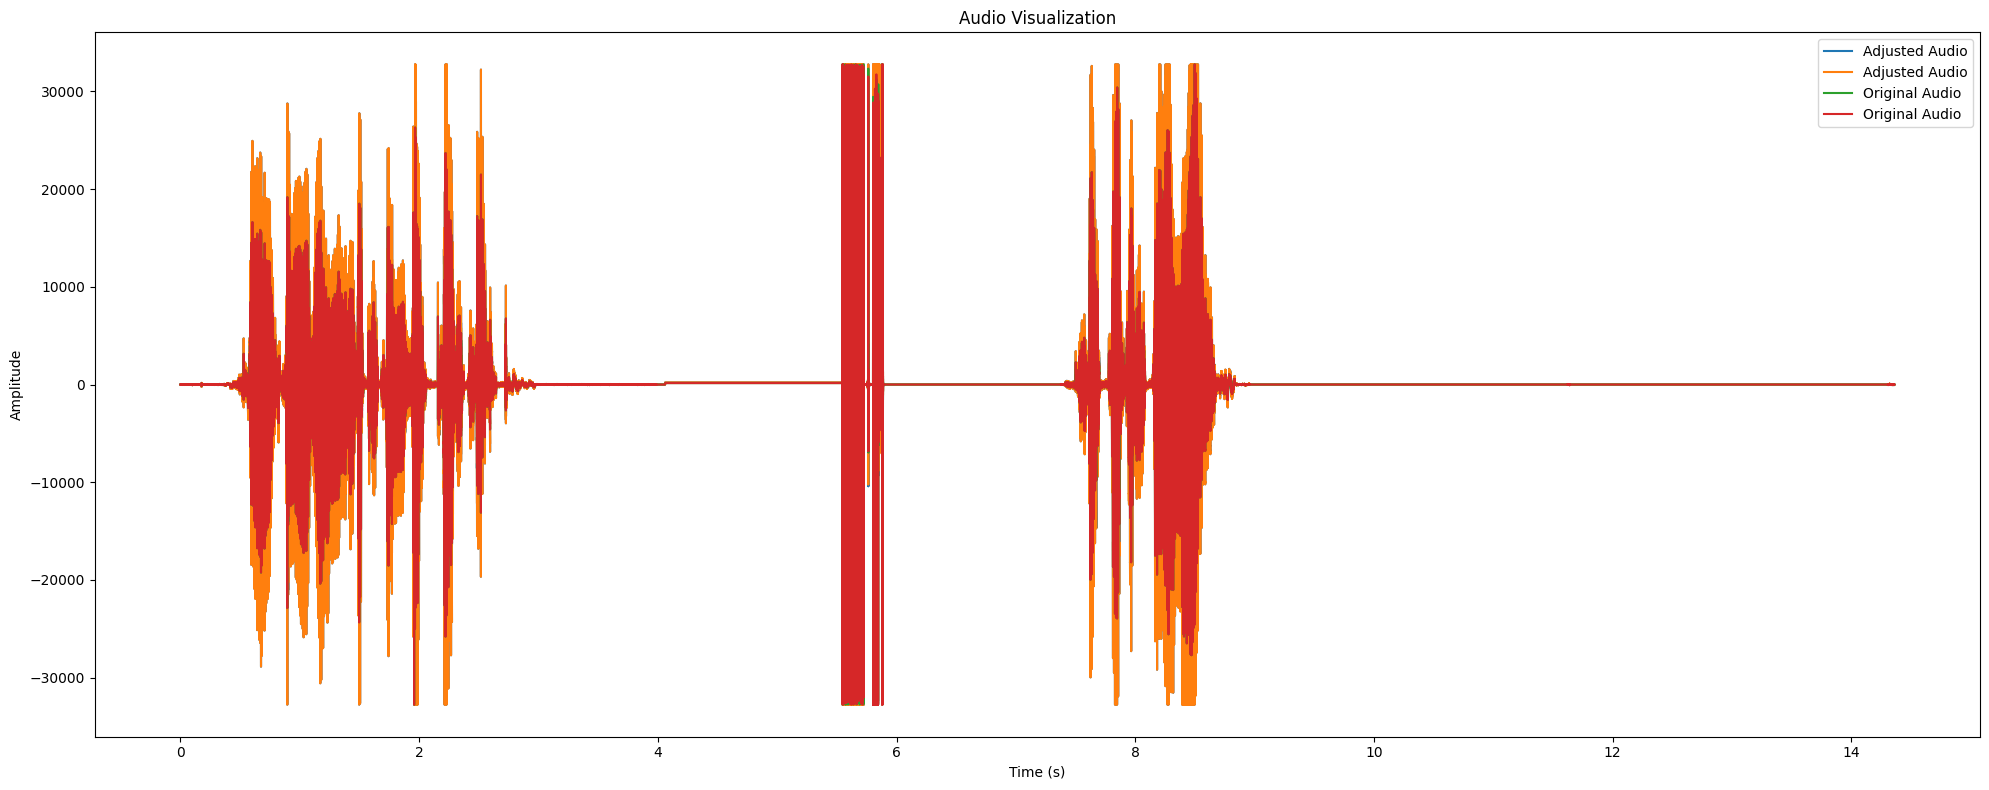

In [8]:
time_axis = np.linspace(0, len(audio_data) / framerate, num=len(audio_data))
plt.figure(figsize=(20, 8))
plt.plot(time_axis, adjusted_audio, label='Adjusted Audio')
plt.plot(time_axis, audio_data, label='Original Audio')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title('Audio Visualization')
plt.legend(); plt.tight_layout(); plt.show()

## Dynamic Range Compression

In [9]:
threshold = max_val * 0.5
ratio = 4
compressed_audio = adjusted_audio.copy()

abs_audio_data = np.abs(compressed_audio)
mask = abs_audio_data > threshold

compressed_audio[mask] = threshold + (compressed_audio[mask] - threshold) / ratio
compressed_audio = np.clip(compressed_audio, -max_val, max_val)


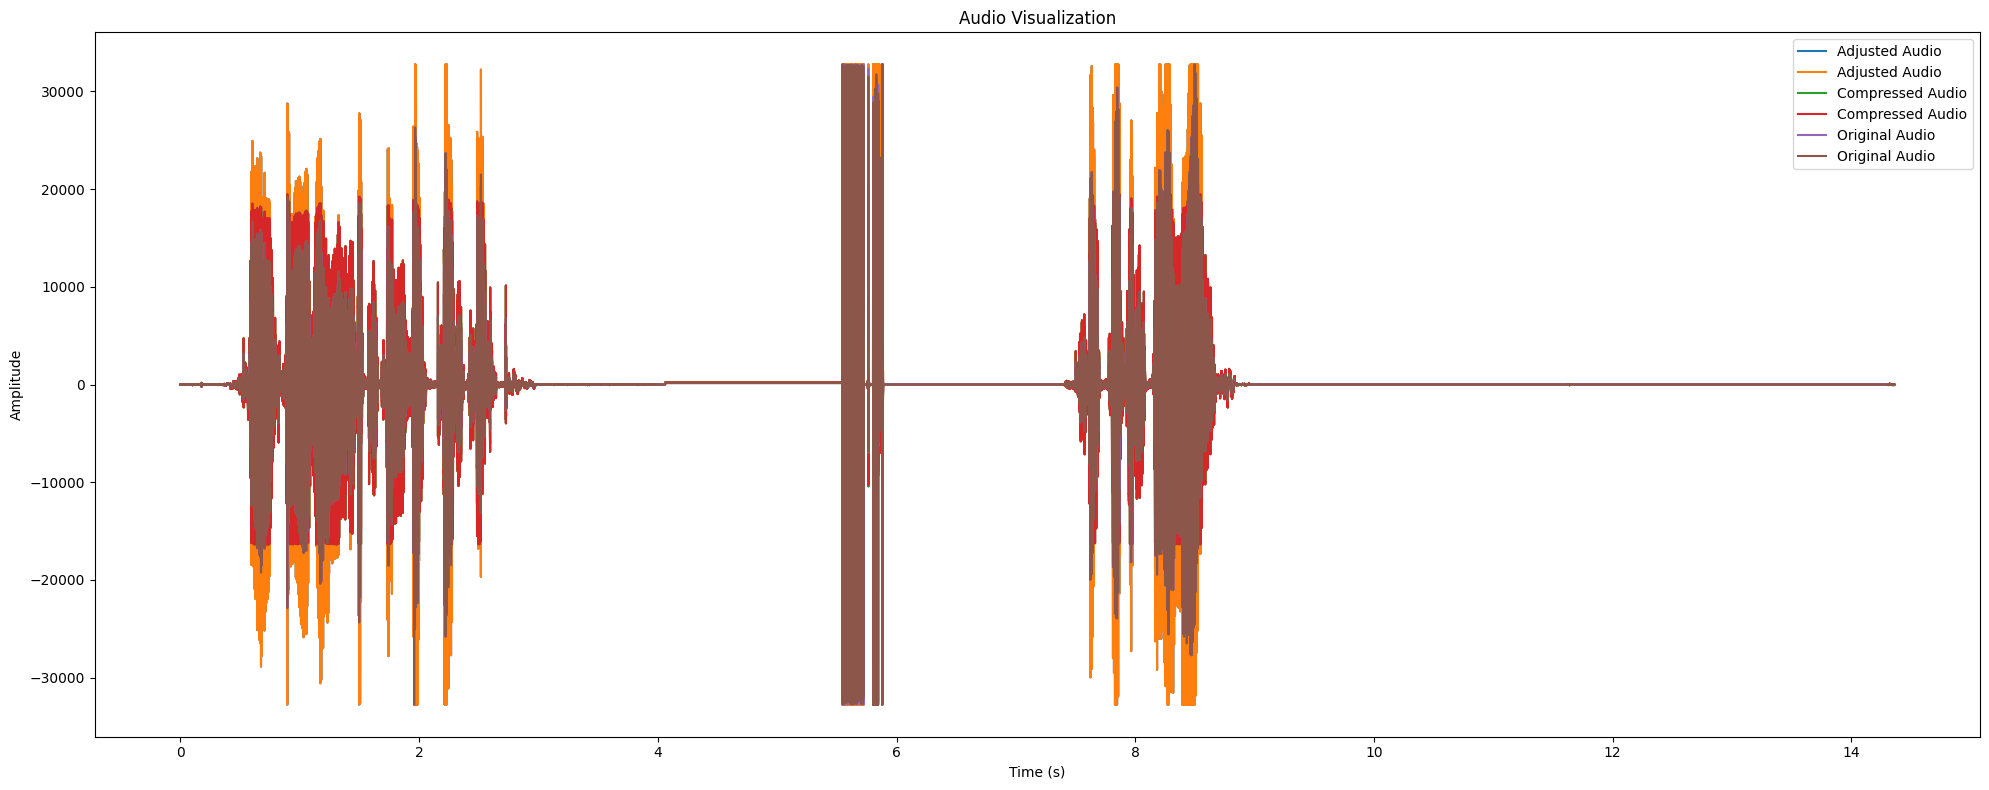

In [10]:

time_axis = np.linspace(0, len(audio_data) / framerate, num=len(audio_data))
plt.figure(figsize=(20, 8))
plt.plot(time_axis, adjusted_audio, label='Adjusted Audio')
plt.plot(time_axis, compressed_audio, label='Compressed Audio')
plt.plot(time_axis, audio_data, label='Original Audio')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title('Audio Visualization')
plt.legend(); plt.tight_layout(); plt.show()

In [11]:

threshold = max_val * 0.5
ratio = 4
compressed_audio = adjusted_audio.copy()

#***HO-1.4. Loudness Meter***

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import os

### Memuat Audio

In [24]:

file_path = os.path.join(os.getcwd(), 'data', '/content/16_44k_PerfectTest.wav')

with wave.open(file_path, 'r') as wav_file:
    n_channels = wav_file.getnchannels()
    sampwidth = wav_file.getsampwidth()
    framerate = wav_file.getframerate()
    n_frames = wav_file.getnframes()
    audio_content = wav_file.readframes(n_frames)
    audio_data = np.frombuffer(audio_content, dtype=np.int16)

    if n_channels > 1:
        audio_data = audio_data.reshape(-1, n_channels)



### Audio Loudness

In [25]:
audio_float = audio_data.astype(np.float32) / np.iinfo(np.int16).max

### Menghitung dbFS

In [26]:
peak_amplitude = np.max(np.abs(audio_float))
dbfs = 20 * np.log10(peak_amplitude)
print(f"Amplitudo puncak dalam dbFS: {dbfs:.2f}")

Amplitudo puncak dalam dbFS: 0.00


### Menghitung RMS

In [27]:
squared_audio = np.square(audio_float)
mean_squared = np.mean(squared_audio)
rms = np.sqrt(mean_squared)
rms_db = 20 * np.log10(rms)
print(f"Level RMS: {rms:.4f}")
print(f"Level RMS dalam dB: {rms_db:.2f} dB")

Level RMS: 0.1040
Level RMS dalam dB: -19.66 dB


### Menghitung True Peak

In [30]:
# Upsample dengan faktor 4 menggunakan numpy
audio_upsampled = np.zeros(len(audio_float) * 4)

# Select one channel from audio_float (assuming you want to upsample only one channel)
audio_float_mono = audio_float[:, 0]  # Select the first channel

audio_upsampled[::4] = audio_float_mono
audio_upsampled = np.convolve(audio_upsampled, np.ones(4)/4, mode='same')

true_peak = np.max(np.abs(audio_upsampled))
true_peak_db = 20 * np.log10(true_peak)
print(f"Level True Peak: {true_peak_db:.2f} dB")

Level True Peak: -12.04 dB


### Menghitung LUFS (disederhanakan)

In [29]:

b = np.array([1.53512485958697, -2.69169618940638, 1.19839281085285])
a = np.array([1.0, -1.69065929318241, 0.73248077421585])
filtered_audio = np.zeros_like(audio_float)
for i in range(len(audio_float)):
    if i < 2:
        filtered_audio[i] = audio_float[i]
    else:
        filtered_audio[i] = (b[0] * audio_float[i] + b[1] * audio_float[i-1] + b[2] * audio_float[i-2]
                             - a[1] * filtered_audio[i-1] - a[2] * filtered_audio[i-2]) / a[0]

# Hitung mean square
ms = np.mean(np.square(filtered_audio))

# LUFS
lufs = -0.691 + 10 * np.log10(ms)
print(f"LUFS: {lufs:.2f}")

LUFS: -18.24


### Ringkasan

In [31]:
print("\nRingkasan pengukuran kekerasan suara:")
print(f"Amplitudo puncak (dbFS): {dbfs:.2f}")
print(f"Level RMS (dB): {rms_db:.2f}")
print(f"Level True Peak (dB): {true_peak_db:.2f}")
print(f"LUFS Terintegrasi: {lufs:.2f}")


Ringkasan pengukuran kekerasan suara:
Amplitudo puncak (dbFS): 0.00
Level RMS (dB): -19.66
Level True Peak (dB): -12.04
LUFS Terintegrasi: -18.24
